# Trainer API를 활용한 Fine Tuning 하기.

### 1. Load package and set environment variable.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import sys
from omegaconf import OmegaConf

from sklearn.metrics import accuracy_score, f1_score

import torch
from datasets import load_dataset
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    EvalPrediction,
    Trainer,
    TrainingArguments,
)
from transformers.integrations import WandbCallback

sys.path.append('/root/nlp-with-transformers')
from src.data import EmotionDataModule

/opt/conda/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(


* 평가지표 정의하기
    * Trainer 내부에서 사용할 `compute_metrics`을 정의함.
    * 모델 학습 과정에서 `EvalPrediction`객체 (has attribute predictions, label_ids)를 전달받아서 평가지표 계산이 가능함.

In [3]:
def compute_metrics(pred:EvalPrediction):
    """Get EvalPrediction and Calculate the metrics"""
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy":acc, "f1":f1}

### 2. Prepare Train

* configuration은 크게 data, model, training쪽을 구분함.

In [4]:
config = OmegaConf.load('conf/ft.yaml')

In [5]:
os.environ['WANDB_PROJECT'] = config.env['wandb']['WANDB_PROJECT']

* load datamodule

In [6]:
tokenizer = AutoTokenizer.from_pretrained(config.model.pretrained_model_name_or_path)
dm = EmotionDataModule(tokenizer=tokenizer, **OmegaConf.to_container(config.data))
dm.setup()

No config specified, defaulting to: emotion/split
No config specified, defaulting to: emotion/split
Found cached dataset emotion (/root/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-805eceb002e5c82e.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-e72b1f240cb76b39.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-363a00d3f7a34dfe.arrow


* 사전학습된 모델 로드

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoModelForSequenceClassification.from_pretrained(
    config.model.pretrained_model_name_or_path, 
    num_labels=dm.num_classes
).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

* 다른 arguments에 의존성이 있는 training args를 정의 및 trainer 실행.

In [8]:
model_base_dir = '/root/model_safari'
config.training.output_dir = f"{model_base_dir}/{config.model.pretrained_model_name_or_path}-finetuned-emotion"
config.training.logging_steps = len(dm.ds['train']) // config.training.per_device_train_batch_size
training_args = TrainingArguments(**OmegaConf.to_container(config.training))

In [9]:
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=dm.ds['train'],
                  eval_dataset=dm.ds['validation'],
                  data_collator=dm.get_collate_fn(),
                  callbacks=[WandbCallback()]
                 )

### 3. Train model and error analysis

In [10]:
trainer.train()

/opt/conda/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: datalama. Use `wandb login --relogin` to force relogin


[2023-01-25 15:10:29.750: W smdistributed/modelparallel/torch/nn/predefined_hooks.py:75] Found unsupported HuggingFace version 4.25.1 for automated tensor parallelism. HuggingFace modules will not be automatically distributed. You can use smp.tp_register_with_module API to register desired modules for tensor parallelism, or directly instantiate an smp.nn.DistributedModule. Supported HuggingFace transformers versions for automated tensor parallelism: ['4.17.0', '4.20.1', '4.21.0']
[2023-01-25 15:10:29.843 ee7736cf838b:5532 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-01-25 15:10:29.981 ee7736cf838b:5532 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.794300,0.269021,0.920000,0.918848
2,0.212400,0.179108,0.927000,0.927222
3,0.146200,0.164048,0.932000,0.932330


TrainOutput(global_step=750, training_loss=0.384301996866862, metrics={'train_runtime': 169.8793, 'train_samples_per_second': 282.554, 'train_steps_per_second': 4.415, 'total_flos': 1078278745731840.0, 'train_loss': 0.384301996866862, 'epoch': 3.0})

* predicts를 통해 예측값을 받을 수 있음.

In [11]:
predicts = trainer.predict(dm.ds['validation'])
predicts

PredictionOutput(predictions=array([[ 5.214697  , -0.908192  , -1.0109664 , -0.8797891 , -1.1317407 ,
        -1.7231724 ],
       [ 5.2343407 , -1.006928  , -1.4200271 , -0.70826936, -0.747143  ,
        -1.6862102 ],
       [-1.2311928 ,  2.5197318 ,  3.1118264 , -1.203115  , -2.0291572 ,
        -1.907203  ],
       ...,
       [-1.2686397 ,  5.199281  , -0.20892029, -1.3117659 , -2.1274428 ,
        -1.433847  ],
       [-1.6041843 ,  3.3147378 ,  2.737571  , -1.4269689 , -2.2262764 ,
        -1.743381  ],
       [-1.3398213 ,  5.162561  , -0.4659274 , -1.7608786 , -2.166939  ,
        -0.6403077 ]], dtype=float32), label_ids=array([0, 0, 2, ..., 1, 1, 1]), metrics={'test_loss': 0.1640477031469345, 'test_accuracy': 0.932, 'test_f1': 0.9323296888610766, 'test_runtime': 1.9942, 'test_samples_per_second': 1002.931, 'test_steps_per_second': 16.047})

* 오차 행렬

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [13]:
def plot_confusion_matrix(y_pred, y_true, labels):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized Confusion matrix")
    plt.show()

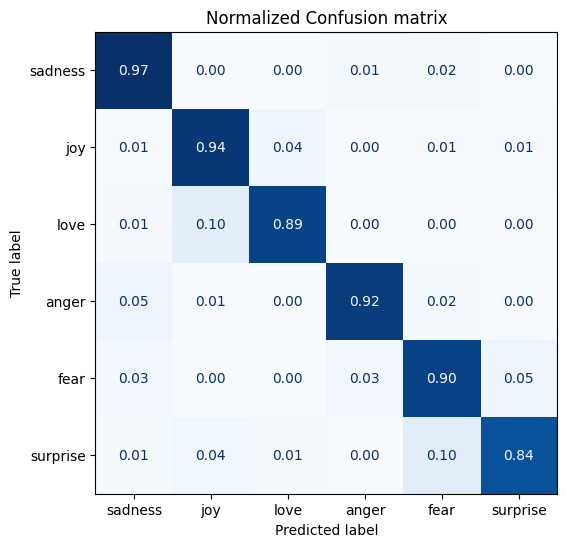

In [14]:
import numpy as np
y_preds = np.argmax(predicts.predictions, axis=1)
plot_confusion_matrix(y_preds, dm.ds['validation']['label'], dm.id2label)

* error analysis
  * 모델의 validation loss가 큰 순으로 정렬하는 것. (가장 심플)

In [104]:
from torch.nn.functional import cross_entropy
vl_dl = trainer.get_eval_dataloader(dm.ds['validation'])
bs = vl_dl.batch_size
vl_loss_dict = {k:list() for k in ["text", "label", "predicted_label", "loss"]}

In [105]:
for i, batch in enumerate(vl_dl):
    vl_loss_dict['text'] += dm.ds['validation']['text'][i*bs:(i+1)*bs]
    vl_loss_dict['label'] += dm.ds['validation']['label'][i*bs:(i+1)*bs].numpy().tolist()
    inputs = {k:v.to(device) for k,v in batch.items()}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["labels"].to(device), 
                             reduction="none")
        
    vl_loss_dict['loss'] += loss.cpu().numpy().tolist()
    vl_loss_dict['predicted_label'] += pred_label.cpu().numpy().tolist()


In [106]:
import pandas as pd
vl_loss_df = pd.DataFrame.from_dict(vl_loss_dict)

In [108]:
vl_loss_df['label'] =vl_loss_df['label'].apply(lambda x:dm.id2label[x])
vl_loss_df['predicted_label'] = vl_loss_df['predicted_label'].apply(lambda x:dm.id2label[x])

* to hedge low-confidence 

In [111]:
vl_loss_df.sort_values('loss', ascending=False).head(10)

,text,label,predicted_label,loss
1111,im lazy my characters fall into categories of ...,joy,fear,5.824722
1500,i guess we would naturally feel a sense of lon...,anger,sadness,5.679358
1963,i called myself pro life and voted for perry w...,joy,sadness,5.505166
1509,i guess this is a memoir so it feels like that...,joy,fear,5.393615
882,i feel badly about reneging on my commitment t...,love,sadness,5.341237
1840,id let you kill it now but as a matter of fact...,joy,fear,5.218733
1950,i as representative of everything thats wrong ...,surprise,sadness,5.107484
318,i felt ashamed of these feelings and was scare...,fear,sadness,4.973043
160,i didnt want to feel outcasted as the uptight ...,fear,sadness,4.439733
1683,i had applied for a job and they had assured m...,anger,joy,4.344048


* to hedge over-confidence

In [114]:
vl_loss_df.sort_values('loss', ascending=True).head(10)

,text,label,predicted_label,loss
400,i are just relaxing together and i feel ecstat...,joy,joy,0.007303
876,i feel like the cool mom,joy,joy,0.007318
452,i manage to complete the lap not too far behin...,joy,joy,0.007333
1873,i feel practically virtuous this month i have ...,joy,joy,0.007378
107,i feel the cool edge of the barrel against my ...,joy,joy,0.007403
632,i feel he is an terrific really worth bet,joy,joy,0.007436
702,i only find out that they are looking and feel...,joy,joy,0.007459
1090,i dont know what it is about me and sweets the...,joy,joy,0.007467
1109,i feel like this semester has been good for me,joy,joy,0.007498
1622,i feel that it was a good investment to make t...,joy,joy,0.007520
